# 233 filtered Articles by inclusion/exclusion criteria
These include Surveys and Position Papers

### Include criteria
* must be a combination of neural and symbolic techniques (NOT comaparisons of same, NOT ensembles of each)
* must be text as input

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
from wordcloud import WordCloud
import utils
import umap
import hdbscan
import importlib
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/nuero-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [2]:
import matplotlib as mpl
plt.style.use('presentation.mplstyle')
mpl.matplotlib_fname()

'/Users/kylehamilton/MyDocuments/ML-Labs/nuero-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/matplotlibrc'

In [3]:
df=pd.read_csv("scopus-filtered-by-on-topic.csv")

In [4]:
print(len(df))

233


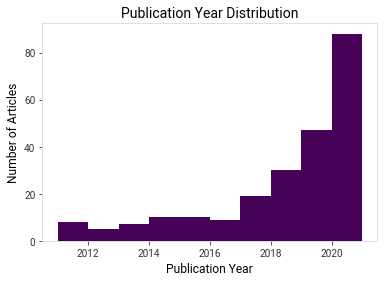

In [5]:
plt.hist(df['Publication Year'])
plt.title('Publication Year Distribution')
plt.xlabel('Publication Year')
plt.ylabel('Number of Articles')
plt.show()

In [5]:
def drawCloud(text):
    wc = WordCloud(background_color="white", 
                   max_words=350, 
                   width=1000, 
                   height=600, 
                   random_state=1).generate(text)

    plt.figure(figsize=(15,15))
    plt.imshow(wc)
    plt.axis("off")

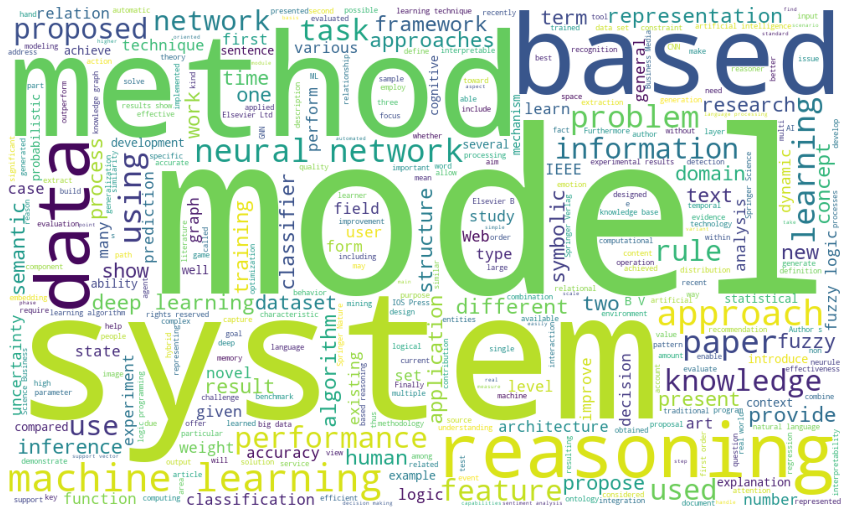

In [6]:
text = ','.join(list(df['Abstract Note']))
drawCloud(text)

## Topics
Use raw text abstracts, or load previously trained embeddings

In [6]:
abstracts = np.array(df['Abstract Note'])

In [7]:
fileName='embeddings1627816190.5488052.txt'
embeddings = np.loadtxt(fileName, delimiter=',')

In [8]:
importlib.reload(utils)
# defaults: make_clusters(data, neighbors=15, components=5, cluster_size=5, save_embeddings=False)
cluster = utils.make_clusters(embeddings,save_embeddings=False)

In [9]:
set(cluster.labels_)

{-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## Visualise clusters

In [10]:
# Prepare data
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

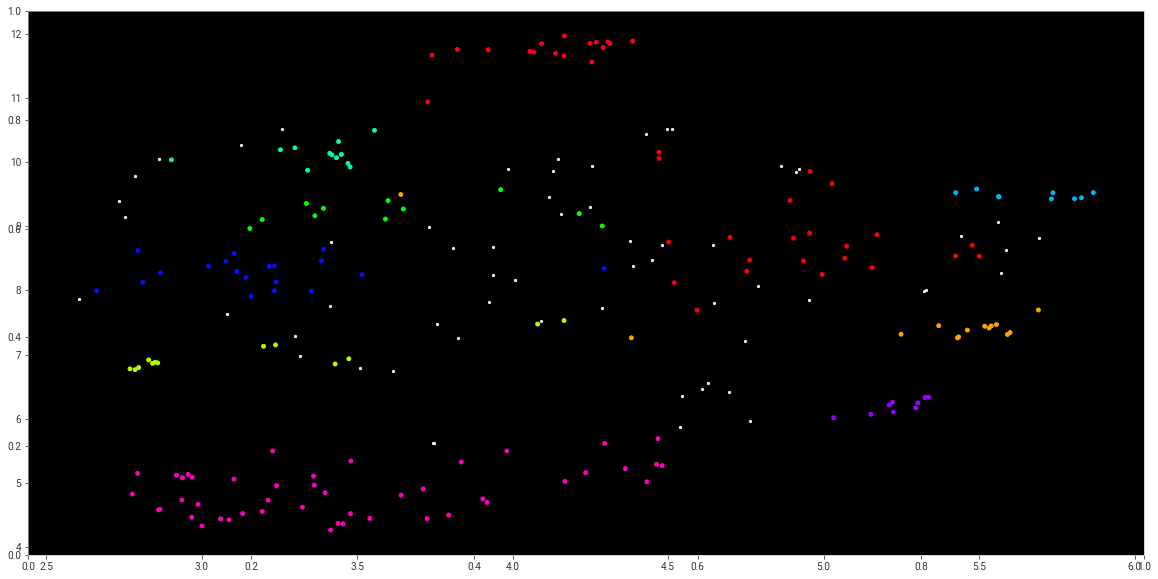

In [11]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
ax = fig.add_subplot(facecolor='#000000')
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#eeeeee', s=5)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=15, cmap='hsv_r')
plt.show()

## Topic keywords

In [12]:
importlib.reload(utils)

<module 'utils' from '/Users/kylehamilton/MyDocuments/ML-Labs/nuero-symbolic-AI/neuro-symbolic-ai-systematic-review/scopus/utils.py'>

In [13]:
top_n_words, topic_sizes = utils.get_topics(cluster, abstracts)

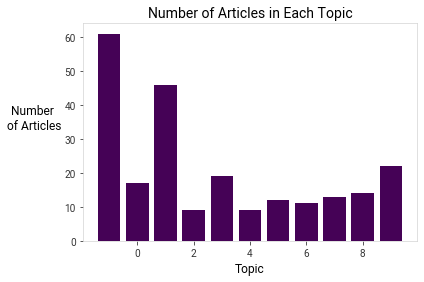

In [15]:
fig, ax = plt.subplots()
plt.bar(topic_sizes['Topic'],topic_sizes['Size'])
plt.title('Number of Articles in Each Topic')
plt.xlabel('Topic')
plt.ylabel('Number \nof Articles',rotation=0,labelpad=30)
plt.show()

In [250]:
# -1 topic are outliers (not part of any topic)

for i in range(0,len(topic_sizes-1)):
    print("Topic: ",topic_sizes["Topic"].iloc[i], "| Size: ", topic_sizes["Size"].iloc[i])
    print("_"*50)
    for j in top_n_words[i-1][:10]:
        print(j[0])
    print("="*50)

Topic:  -1 | Size:  85
__________________________________________________
probabilistic
web
features
provide
feature
temporal
big
semantic
ontology
methods
Topic:  3 | Size:  32
__________________________________________________
sentiment
emotion
rate
idf
social
fdlc
negative
analysis
video
crowd
Topic:  0 | Size:  17
__________________________________________________
neurules
neurule
connectionist
oriented
rules
adaline
symbolic
rough
base
reduction
Topic:  5 | Size:  14
__________________________________________________
cloud
forecasting
load
dl
services
power
provisioning
workloads
resources
south
Topic:  6 | Size:  14
__________________________________________________
fuzzy
output
quadratic
kernel
weights
local
layer
technology
intelligent
functions
Topic:  8 | Size:  14
__________________________________________________
cognitive
cfs
patterns
conceptual
symbolic
sub
dynamics
cognition
dynamical
architectures
Topic:  4 | Size:  13
__________________________________________________


# Citation networks
Create a citation graph based on authors (not papers). Use it to find most "infuential" authors by performing PageRank

In [16]:
df=pd.read_csv("scopus (233).csv")

In [17]:
# df['References']

In [18]:
# we only care about authors and references for this graph.
dfc=df[['Authors','References']]

In [19]:
# authors are separated by a comma. Create a list by splitting on ,
df_auth=df[['Authors','References']]
df_auth['Authors']=df_auth['Authors'].str.split(pat=",")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [20]:
# put each author in their own row
df_auth=df_auth.set_index(['References']).apply(pd.Series.explode).reset_index()

In [21]:
df_auth['References']=1

## Authors with most articles

In [22]:
auth_count=df_auth.groupby(['Authors']).count().reset_index()
auth_count=auth_count.sort_values(by='References', ascending=False)
auth_count=auth_count[auth_count['References']>1]
auth_count.rename(columns = {'References': 'Article Count', 'Authors': 'Author'}, inplace = False).head(10)
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,Author,Article Count
453,Wang H.,5
323,Pedrycz W.,4
230,Li J.,4
483,Xu D.-L.,3
500,Yang J.-B.,3
452,Wang G.,3
245,Liu Y.,3
152,Hao Y.,3
729,Wang Q.,3
232,Li Y.,3


In [23]:
# references are separated by a semi-colon. Create a list by splitting on ;
dfc['References']=dfc['References'].str.split(pat=";")

/Users/kylehamilton/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
# put each citation in its own row
dfc=dfc.set_index(['Authors']).apply(pd.Series.explode).reset_index()

### Get the author names from the citation
`(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,`   
As far as I can tell, this captures the author names pretty well:
<img src="authors-regex-example.jpg">

In [25]:
# Extracts authors from the references and creates new row for each
dfc[['ref_Id','match','ref_Author']]=dfc['References'].str.extractall(pat=r"(([À-ŽA-z|\-|\']\s?)+,?\s(\-?[À-Ž|A-Z]\.)+)\,").reset_index()[['level_0','match',0]]

In [26]:
# remove redundant columns
dfc=dfc[['Authors','ref_Id','ref_Author']]

In [27]:
# authors are separated by a comma. Create a list by splitting on ,
dfc['Authors']=dfc['Authors'].str.split(pat=",")

## Authors most frequently referenced

In [28]:
ref_auth_count=dfc.groupby(['ref_Author']).count().sort_values(by='Authors', ascending=False)
ref_auth_count=ref_auth_count.reset_index()
ref_auth_count=ref_auth_count[ref_auth_count['Authors']>20]
ref_auth_count.rename(columns = {'Authors': 'Reference Count','ref_Author':'Reference Author'}, inplace = False).drop(['ref_Id'],axis=1)
# plt.bar(auth_count['ref_Author'],auth_count['Authors'])

,Reference Author,Reference Count
0,"Bengio, Y.",55
1,"De Raedt, L.",39
2,"Riedel, S.",35
3,"Socher, R.",30
4,"Liu, Z.",28
5,"Rocktäschel, T.",28
6,"Tenenbaum, J.B.",27
7,"Hitzler, P.",27
8,"Bordes, A.",26
9,"Kimmig, A.",26


In [29]:
# put each author in their own row
dfc=dfc.set_index(['ref_Id','ref_Author']).apply(pd.Series.explode).reset_index()

In [30]:
# now we have a cartesian-join of authors 
dfc

,ref_Id,ref_Author,Authors
0,0,"Paredes, J.N.",Paredes J.N.
1,0,"Paredes, J.N.",Simari G.I.
2,0,"Paredes, J.N.",Martinez M.V.
3,0,"Paredes, J.N.",Falappa M.A.
4,0,"Simari, G.I.",Paredes J.N.
...,...,...,...
43616,4149,"Li, J.",De La Rosa J.-L.
43617,4149,"Li, J.",Kovalerchuk B.
43618,4149,"Wang, S.",Galitsky B.
43619,4149,"Wang, S.",De La Rosa J.-L.


In [31]:
# remove commas from the ref_Author so the format matches that of Authors
dfc['ref_Author'].replace(',','', regex=True, inplace=True)

In [32]:
ref_author_nodes=dfc['ref_Author'].unique()

In [33]:
author_nodes=dfc['Authors'].unique()

In [92]:
# author_nodes

In [35]:
len(author_nodes)

758

In [36]:
len(ref_author_nodes)

6659

In [93]:
# Cross reference authors
# set(ref_author_nodes).intersection(set(author_nodes))

In [38]:
len(set(ref_author_nodes).intersection(set(author_nodes)))

98

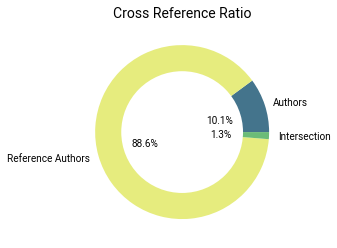

In [39]:
Keys = ['Authors', 'Reference Authors', 'Intersection']
Values = [758, 6659, 98]
colors = ['#44748c', '#e6ec7e','#6cbc78']

plt.pie(Values, colors=colors, labels=Keys,
        autopct='%1.1f%%', pctdistance=.45)
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Cross Reference Ratio')
plt.show()

In [40]:
# !pip install matplotlib-venn

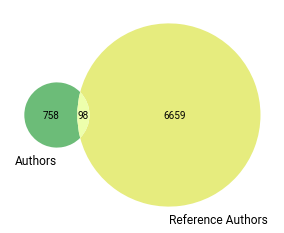

In [41]:
from matplotlib_venn import venn2
venn2(subsets = (758, 6659, 98), set_labels = ('Authors', 'Reference Authors'), alpha=1, set_colors=('#6cbc78', '#e6ec7e'),)
plt.show()

In [182]:
# group by author, concatenate ref_author
dfc=dfc.groupby(['Authors'], as_index = False).agg({'ref_Author': ','.join})

In [183]:
dfc

,Authors,ref_Author
0,Aamodt A.,"Wang Z.,Busemeyer J.R.,Burgess C.,Lund K.,Busemeyer J.R.,Pothos E.M.,Franco R.,Trueblood J.,Caliskan A.,Bryson J.J.,Narayanan A.,Chater N.,Oaksford M.,Cole J.R.,Ghafurian M.,Reitter D.,Cole J.R.,Reitter D.,Cox G.E.,Kachergis G.,Recchia G.,Jones M.N.,Dimov C.M.,Ebbinghaus H.,Eliasmith C.,Franklin D.R.J.,Mewhort D.J.K.,Franklin S.,Madl T.,Strain S.,Faghihi U.,Dong D.,Kugele S.,Snaider J.,Chen S.,Fredrickson B.L.,Gayler R.W.,Gonzalez C.,Ben-Asher N.,Gonzalez C.,Lerch J.F.,Lebiere C.,Griffiths T.L.,Steyvers M.,Tenenbaum J.B.,Heathcote A.,Brown S.,Mewhort D.J.K.,Hertwig R.,Barron G.,Weber E.U.,Erev I.,Hintzman D.L."
1,Abdallah S.,"Liu X.,Giles C.L.,Che Z.,Purushotham S.,Liu Y.,Adler P.,Ribeiro M.T.,Ross A.S.,Hughes M.C.,Doshi-Velez F.,Koh P.W."
2,Abdolali A.,"Jamieson R.K.,Avery J.E.,Johns B.T.,Jones M.N.,Jamieson R.K.,Crump M.J.C.,Hannah S.D.,Johns B.T.,Jones M.N.,Mewhort D.J.K.,Johns B.T.,Taler V.,Pisoni D.B.,Farlow M.R.,Hake A.M.,Kareken D.A.,Unverzagt F.W.,Jones M.N.,Jones M.N.,Kintsch W.,Mewhort D.J.K.,Jones M.N.,Mewhort D.J.K.,Kanerva P.,Kanerva P.,Kant I.,Kelly M.A.,Blostein D.,Mewhort D.J.K.,Kelly M.A.,Ghafurian M."
3,Abraham A.,"Kriegel H.-P.,Socher R.,Xiao H.,Huang M.,Zhu X.,Ji G.,Xiao H.,Schoenmackers S.,Lao N.,Cohen W.W.,Lao N.,Cohen W.W.,Toutanova K.,Lao N.,Mitchell T.,Cohen W.W.,Xiong W.,Hoang T.,Wang W.Y.,Das R.,Xi V.L.,Socher R.,Xiong C.,Shen Y.,Battaglia Peter W.,eroski S.,De Raedt L.,Blockeel H.,eroski S.,De Raedt L.,Driessens K.,Kipf T.N.,Welling M.,Denil M.,Das R.,Le N.-T.,Rummery Gavin A.,Niranjan M.,Babaeizadeh M.,Ding S.,Zhao X.,Aengchuan P.,Phruksaphanrat B.,Ahmad M.W.,Reynolds J.,Rezgui Y.,Azizi A.,Babapour Mofrad R.,Schoonenboom N.S.M.,Tijms B.M.,Scheltens P.,Visser P.J.,van der Flier W.M.,Teunissen C.E.,Bai Y.,Sun Z.,Zeng B.,Long J.,Li L.,de Oliveira J.V.,Li C.,Bockstaller C.,Beauchet S."
4,Afsharchi M.,"Chu L.,Hu X.,Hu J.,Wang L.,Pei J.,Erhan D.,Bengio Y.,Courville A.,Vincent P.,Ngiam J.,Khosla A.,Kim M.,Nam J.,Lee H.,Ng A.Y.,Dosovitskiy A.,Brox T.,Yosinski J.,Clune J.,Fuchs T.,Lipson H.,Zhou B.,Bau D.,Oliva A.,Torralba A.,Cao C.,Wu M.,Hughes M.C.,Parbhoo S.,Zazzi M.,Roth V.,Doshi-Velez F.,Fan L.,Hinton G.,Vinyals O.,Dean J.,Wang Q.,Zhang K.,Ororbia II A.G.,Xing X."
...,...,...
753,Zhu W.,"Socher R.,Manning C.,Joulin A.,Grave E.,Bojanowski P.,Douze M.,Jégou H.,Mikolov T.,Harris Z.S.,Baader F.,Küsters R.,Molitor R.,Lin Y.,Liu Z.,Sun M.,Liu Y.,Zhu X.,Pesquita C.,Faria D.,Falcão A.O.,Lord P.,Couto F.M.,Janowicz K.,Wilkes M.,Rada R.,Mili H.,Bicknell E.,Blettner M.,Caviedes J.E.,Cimino J.J.,Ge J.,Qiu Y.,Jaccard P.,Racharak T.,Suntisrivaraporn B.,Baader F.,Gil O.F.,Marantidis P.,Distel F.,Atif J.,Bloch I.,Chen J.,Althagafi A.,Hoehndorf R.,Smaili F.Z.,Gao X.,Hoehndorf R.,Kulmanov M.,Liu-Wei W.,Yan Y.,Hoehndorf R.,Miller T.,Aharrane N.,El Moutaouakil K.,Satori K.,Aizawa A.,Akhtar N.,Qureshi M.N.,Ahamad M.V.,Ansari A.Q.,Biswas R.,Aggarwal S.,Bounabi M.,El Moutaouakil K."
754,Zia T.,"Fu L.,Fürnkranz J.,Widmer G.,Gu X.,Zhang C.,Ni T.,Hailesilassie T.,Hawkins S.,He H.,Williams G.,Baxter R.,Huang Z.,Gedeon T.D.,Nikravesh M.,Hunt K.J.,Haas R.,Murray-Smith R.,Jang J.-S.,Jiao L.,Denoeux T.,Pan Q.,Kégl B.,Linder T.,Lugosi G.,Kingma D.P.,Ba J.,Le T.,Stahl F.,Gaber M.M.,Gomes J.B.,Di Fatta G.,LeCun Y.,Matan O.,Boser B.,Denker J.S.,Henderson D.,Howard R.E.,Hubbard W.,Baird H.S.,Li J.,Zhang J.,Pang N.,Qin X.,Lughofer E.,Richter R.,Neissl U.,Heidl W.,Eitzinger C.,Radauer T.,Lughofer E.D.,Mahoney M.V.,Chan P.K.,Mangasarian O.,Street W.,Wolberg W.,Michalski R.S.,theory A.,Michalski R.S.,Mozetic I.,Hong J.,Lavrac N.,Nguyen D.T.,Cios K.J."
755,van Bekkum M.,"Toutanova K.,Duchi J.,Hazan E.,Singer Y.,Guo S.,Wang Q.,Wang L.,Wang B.,Guo L.,Hamaguchi T.,Oiwa H.,Shimbo M.,Matsumoto Y.,Hohenecker P.,Lukasiewicz T.,Ji G.,He S.,Xu L.,Liu K.,Zhao J.,Kazemi S.M.,Poole D.,Kingma D.P.,Ba J.,Lin Y.,Liu Z.,Sun M.,Liu Y.,Zhu X.,Liu H.,Wu Y.,Yang Y.,Mikolov T.,Chen K.,Corrado G.,Dean J.,Mikolov T.,Grave E.,Bojanow

In [598]:
import csv
dfc.to_csv('authors.adjlist', index=False,header=False, quoting=csv.QUOTE_NONE, quotechar='',escapechar=' ')

## To do a paper citation network, extract the paper titles instead of the authors from the citations

In [42]:
pd.set_option('display.max_colwidth', None)

In [43]:
dft=pd.read_csv("scopus (233).csv")

In [44]:
dft=dft[['Title','References']]

In [45]:
#references are separated by a semi-colon. Create a list by splitting on ;
dft['References']=dft['References'].str.split(pat=";")

In [46]:
# put each citation in its own row
dft=dft.set_index(['Title']).apply(pd.Series.explode).reset_index()

In [47]:
#dft

In [48]:
# Everything between the last comma and the first parentheses (sadly includes the comma, so remove it in second step)
# (?:.(?!\,))+?(?=\()

In [49]:
dft['References']=dft['References'].str.extract(pat=r"((?:.(?!\,))+?(?=\())")
dft['References']=dft['References'].str.replace(',\s','', regex=True)

In [50]:
dft['Title']=dft['Title'].str.lower()
dft['References']=dft['References'].str.lower()
dft['Title']=dft['Title'].str.strip()
dft['References']=dft['References'].str.strip()

In [54]:
# Cross referenced articles (These are articles in all the references which are also in the primary list of articles)
len(set(dft['Title']).intersection(set(dft['References'])))

24

In [52]:
len(set(dft['Title']))

230

In [53]:
len(set(dft['References']))

8307

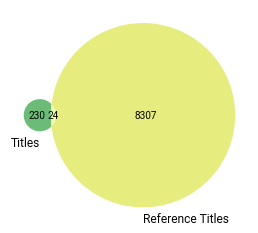

In [55]:
from matplotlib_venn import venn2
venn2(subsets = (230, 8307, 24), set_labels = ('Titles', 'Reference Titles'), alpha=1, set_colors=('#6cbc78', '#e6ec7e'),)
plt.show()

# Graph Analysis

In [56]:
import networkx as nx

In [57]:
G = nx.read_adjlist("authors.adjlist", delimiter=",", create_using=nx.DiGraph)

In [58]:
nx.info(G)

'Name: \nType: DiGraph\nNumber of nodes: 7519\nNumber of edges: 38262\nAverage in degree:   5.0887\nAverage out degree:   5.0887'

In [59]:
# sanity check
nx.is_directed(G)

True

In [60]:
nx.number_connected_components(G.to_undirected())

5

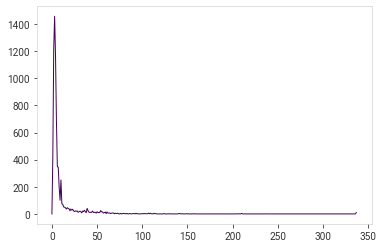

In [61]:
plt.plot(nx.degree_histogram(G))

## In-degree centrality

In [604]:
in_deg=nx.in_degree_centrality(G)

In [605]:
in_degTups=[(k,v) for k,v in in_deg.items()]
in_degDF=pd.DataFrame.from_records(in_degTups,columns=['author','in-degree'])

# Top 10 Authors by indegree
in_degDF.sort_values(by='in-degree',ascending=False).head(10)

,author,in-degree
141,Bengio Y.,0.015297
1019,Liu Z.,0.013301
100,De Raedt L.,0.010641
88,Cohen W.W.,0.009311
138,Wang L.,0.009178
81,Socher R.,0.009045
1507,Zhang Y.,0.008779
429,Riedel S.,0.008779
84,Zhu X.,0.008646
656,Zhang Z.,0.008646


In [618]:
list(nx.all_neighbors(G, 'Bengio  Y. '))

['Afsharchi  M.',
 'Bianchi  F.',
 'Chang  Y.-C.',
 'Chen  D.',
 'Condeço  J.',
 'Corchuelo  R.',
 'Csiszár  G.',
 'Cussens  J.',
 "D'Avila  Garcez  A.S.",
 'De  Raedt  L.',
 'Demeester  T.',
 'Dombi  J.',
 'Dumančić  S.',
 'Ebrahimi  M.',
 'Espinasse  B.',
 'Fdez-Riverola  F.',
 'Freitas  F.',
 'Garcez  A.A.',
 'Gentili  R.J.',
 'Gershman  S.J.',
 'Goodman  N.D.',
 'Gori  M.',
 'Guo  D.',
 'Han  L.',
 'Hohenecker  P.',
 'Jain  M.',
 'Johnson-Laird  P.N.',
 'Katz  G.E.',
 'Khorrami  F.',
 'Kimmig  A.',
 'Liang  C.',
 'Lin  C.-T.',
 'Lourenço  A.',
 'Lukasiewicz  T.',
 'Manrique  D.',
 'McDonough  J.',
 'Mirbakhsh  N.',
 'Nasraoui  O.',
 'Norman  T.J.',
 'Pandey  H.M.',
 'Parsons  S.',
 'Rabkina  I.',
 'Raj  B.',
 'Reggia  J.A.',
 'Riguzzi  F.',
 'Rosé  C.P.',
 'Roth  D.',
 'Saccà  C.',
 'Sammons  M.',
 'Sanders  S.',
 'Sarker  M.K.',
 'Sarmadi  A.',
 'Serrano  E.',
 'Shi  Y.',
 'Si  C.',
 'Silva  S.',
 'Soh  H.',
 'Stenning  K.',
 'Su  S.-F.',
 'Sun  L.',
 'Trujillo  L.',
 'Vittorini  

## PageRank centrality

In [611]:
pagerank=nx.pagerank(G)

In [612]:
pagerankTups=[(k,v) for k,v in pagerank.items()]

In [613]:
pagerankDF=pd.DataFrame.from_records(pagerankTups,columns=['author','pr'])

In [614]:
# Top 10 Authors
pagerankDF.sort_values(by='pr',ascending=False).head(10)

,author,pr
875,Chakraborty S.,0.001573
4605,Peng Y.I.,0.000744
605,Xiao F.,0.000537
2509,Mendes P.N.,0.000439
5108,Brun Y.,0.000436
4530,Socher R.,0.000434
141,Bengio Y.,0.000338
4639,Biswas A.,0.000335
1019,Liu Z.,0.000289
429,Riedel S.,0.000265


# Keyword analysis

In [62]:
pd.set_option('display.max_colwidth', None)
dfk=pd.read_csv("scopus (233).csv")

In [63]:
dfk=dfk[['Author Keywords','Index Keywords']]
dfk=dfk.dropna()

In [64]:
dfk=dfk.astype(str)
dfk['all_keywords']=dfk[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
dfk = dfk.reset_index()
dfk = dfk.set_index('index').reset_index()

In [65]:
dfk['all_keywords']=dfk['all_keywords'].str.split(pat=";")

In [66]:
dfk=dfk.set_index(['index']).apply(pd.Series.explode).reset_index()

In [67]:
dfk=dfk[['index','all_keywords']]

In [68]:
dfk=dfk.groupby('all_keywords').count().reset_index().sort_values(by='index', ascending=False)

In [69]:
# dfk=dfk[dfk['index']>15]

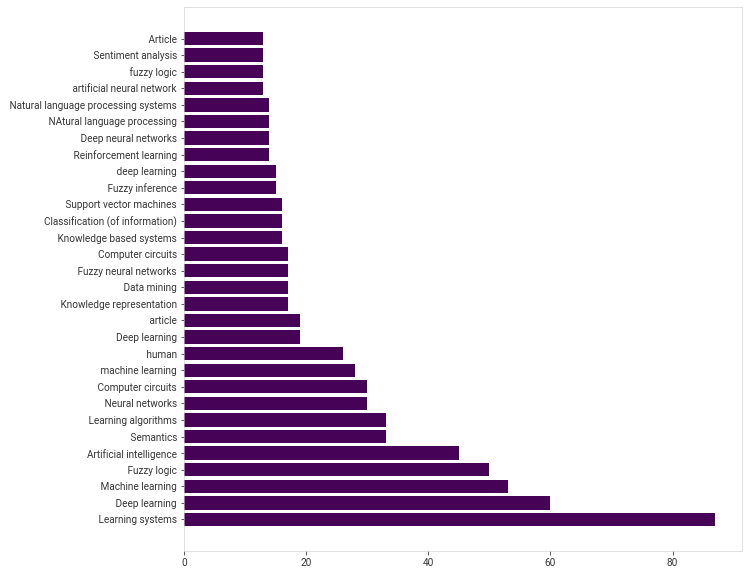

In [71]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.barh(dfk['all_keywords'].head(30),dfk['index'].head(30))
plt.show()

## Keyword wordcloud

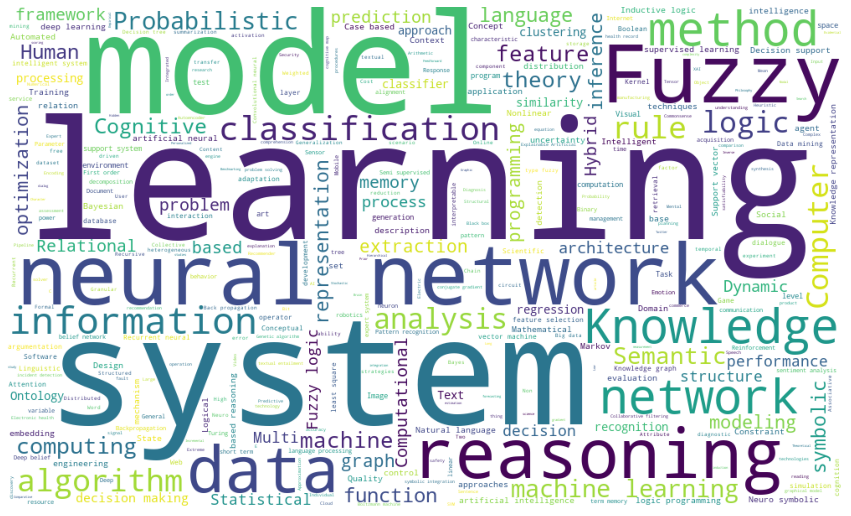

In [957]:
text = ','.join(list(dfk['all_keywords']))
drawCloud(text)

## Market-basket analysis on keywords
### Frequent itemsets

$$ Support=\frac{\#(X,Y)}{N} $$

$$ Confidence=\frac{\#(X,Y)}{\#(X)} $$

$$ Lift=\frac{Support}{Support(X)\times Support(Y)} $$

In [17]:
# !pip install mlxtend

In [72]:
pd.set_option('display.max_colwidth', None)
baskets=pd.read_csv("scopus (233).csv")

In [73]:
baskets=baskets[['Author Keywords','Index Keywords']]
baskets=baskets.dropna()

In [74]:
baskets=baskets.astype(str)
baskets['all_keywords']=baskets[['Author Keywords','Index Keywords']].agg(';'.join, axis=1)
baskets['Author Keywords']=baskets['Author Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['Index Keywords']=baskets['Index Keywords'].map(lambda x: x.lower()).str.split(pat=";")
baskets['all_keywords']=baskets['all_keywords'].map(lambda x: x.lower()).str.split(pat=";")

In [75]:
keywords='all_keywords'
dataset=baskets[keywords]

In [76]:
from mlxtend.frequent_patterns import fpgrowth,fpmax, apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
# http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns=te.columns_)
# df

In [77]:
# combination appears in <support> ratio of dataset, ie 0.05 means this combination of keywords appears in 5% of the dataset
support=0.05 
freq_items=fpgrowth(df, min_support=support, use_colnames=True)

In [94]:
# for i in freq_items.sort_values(by='support',ascending=False)['itemsets']:
#     print(i)

In [79]:
rules = association_rules(freq_items, min_threshold=0.01)

In [80]:
rules.sort_values(by='support',ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,( machine learning),( learning systems),0.338462,0.441026,0.153846,0.454545,1.030655,0.004576,1.024786
11,( learning systems),( machine learning),0.441026,0.338462,0.153846,0.348837,1.030655,0.004576,1.015934
53,(artificial intelligence),( learning systems),0.210256,0.441026,0.148718,0.707317,1.603800,0.055989,1.909829
52,( learning systems),(artificial intelligence),0.441026,0.210256,0.148718,0.337209,1.603800,0.055989,1.191543
69,( learning systems),( fuzzy logic),0.441026,0.225641,0.138462,0.313953,1.391385,0.038948,1.128727
...,...,...,...,...,...,...,...,...,...
64,( article),( deep learning),0.164103,0.271795,0.051282,0.312500,1.149764,0.006680,1.059207
65,( deep learning),( article),0.271795,0.164103,0.051282,0.188679,1.149764,0.006680,1.030292
66,( human),( humans),0.133333,0.056410,0.051282,0.384615,6.818182,0.043761,1.533333
67,( humans),( human),0.056410,0.133333,0.051282,0.909091,6.818182,0.043761,9.533333


## Association Rules heatmap

In [81]:
from collections import defaultdict
antecendents=rules['antecedents'].map(lambda x: ';'.join(list(x)).strip())
consequents=rules['consequents'].map(lambda x: ';'.join(list(x)).strip())
support=rules['support']

zipped=zip(antecendents,consequents,support)

d=defaultdict(dict)

for i in list(zipped):
    d[i[0]][i[1]]=i[2]

In [82]:
# for k, v in d.items():
#     print(k)
#     print(v)
#     print("-"*20)
#     for i,j in v.items():
#         print(i, j)
#     print("="*50)    

In [83]:
assd=pd.DataFrame(d)

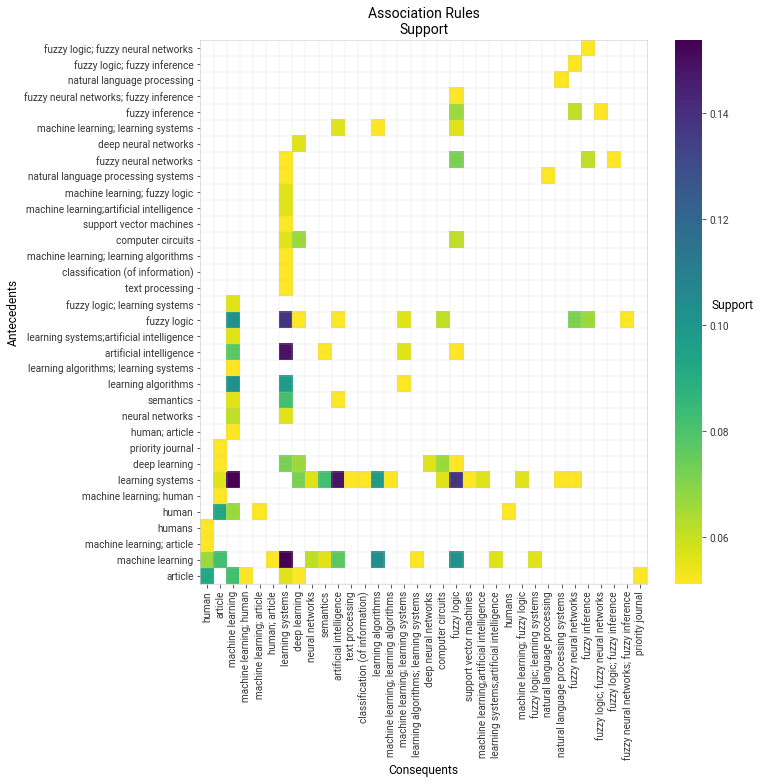

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()

plt.hlines(y=np.arange(0, len(assd.index), 1), xmin=np.full(len(assd.index),0), xmax=np.full(len(assd.index),len(assd.index)), color="#cccccc", linewidth=.25)
plt.vlines(x=np.arange(0, len(assd.columns), 1), ymin=np.full(len(assd.index),0), ymax=np.full(len(assd.index),len(assd.index)), color="#cccccc",linewidth=.25)
plt.yticks(np.arange(0.5, len(assd.index), 1), assd.index)
plt.xticks(np.arange(0.5, len(assd.columns), 1), assd.columns, rotation=90)
plt.ylabel("Antecedents")
plt.xlabel("Consequents")
plt.title("Association Rules\nSupport")

graph=plt.pcolor(assd, cmap=reversed_color_map)
cb = fig.colorbar(graph)
cb.set_label('Support', rotation=0, va='bottom')
cb.outline.set_visible(False)
plt.show()

## Association Rules Scatterplot

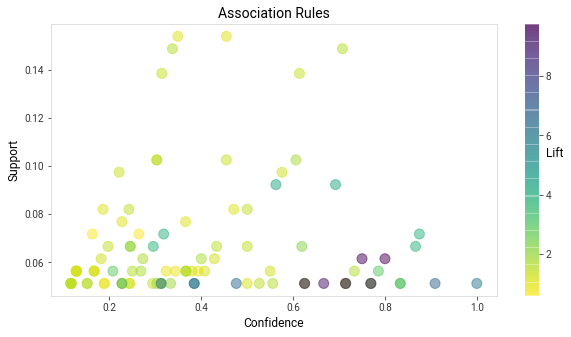

In [91]:
fig, ax = plt.subplots(figsize=(10, 5))
color_map = plt.cm.get_cmap('viridis')
reversed_color_map = color_map.reversed()
graph=plt.scatter(rules['confidence'],rules['support'],c=rules['lift'],s=100,alpha=0.5, cmap=reversed_color_map)

cb = fig.colorbar(graph)
cb.set_label('Lift', rotation=0, va='bottom')
cb.outline.set_visible(False)

plt.title('Association Rules')
plt.xlabel('Confidence')
plt.ylabel('Support')
plt.show()